In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#get data
eurusd = pd.read_csv(r'eurousd.csv', index_col=0, parse_dates=True, skipinitialspace=True)
dataset = eurusd.Open.values #numpy.ndarray
dataset

array([1.0085 , 1.0255 , 1.0304 , ..., 1.10882, 1.10925, 1.10953])

In [3]:
# Reshape data
dataset = np.reshape(dataset, (-1, 1))
dataset

array([[1.0085 ],
       [1.0255 ],
       [1.0304 ],
       ...,
       [1.10882],
       [1.10925],
       [1.10953]])

In [4]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# get the scaling model so it can be reused again later; use  2 step process instead of fit_transform
scaling_model = sc.fit(dataset)
dataset_scaled = scaling_model.transform(dataset)
print(dataset[0:5, ])
print(dataset_scaled[0:5, ])

[[1.0085]
 [1.0255]
 [1.0304]
 [1.032 ]
 [1.0317]]
[[0.23546926]
 [0.25747573]
 [0.26381877]
 [0.26588997]
 [0.26550162]]


In [5]:
train_size = int(len(dataset_scaled) * 0.80)

test_size = len(dataset_scaled) - train_size

train, test = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset_scaled),:]
print(train_size)
print(test_size)

4149
1038


In [6]:
# Create a data structure with 60 timestamps and 1 output
X_train = []
y_train = []
for i in range(60, len(dataset_scaled)):
    X_train.append(dataset_scaled[i-60:i, 0])
    y_train.append(dataset_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [7]:
# Use scalping model
dataset_total = pd.concat((eurusd.Open.iloc[0:4149], eurusd.Open.iloc[4149:len(dataset)]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test):].values
inputs = inputs.reshape(-1,1)
inputs = scaling_model.transform(inputs)


In [8]:
dataset_total = pd.concat((eurusd.Open.iloc[0:4149], eurusd.Open.iloc[4149:len(dataset)]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, 1098):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(dataset_scaled[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))

In [9]:
# Reshape data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [11]:
inputs.shape

(1098, 1)

#### BUILD RNN MODEL

In [12]:
# Importing the Keras Libarrios and Packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [13]:
# Initializing the RNN

regressor = Sequential()

In [14]:
# Adding the first LSTM Layer and some Droupout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [15]:
# Adding the second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [16]:
# Adding the third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [17]:
# Adding the fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [18]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [19]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [20]:
# Fitting the RNN to the training set
es = EarlyStopping(monitor='val_loss', mode='min',  patience=5, verbose=1)
regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 100, batch_size = 30, callbacks=[es])

Train on 5127 samples, validate on 1038 samples
Epoch 1/100
5127/5127 [==============================] - 28s 5ms/step - loss: 0.0093 - val_loss: 0.0551
Epoch 2/100
5127/5127 [==============================] - 30s 6ms/step - loss: 0.0036 - val_loss: 0.0628
Epoch 3/100
5127/5127 [==============================] - 29s 6ms/step - loss: 0.0032 - val_loss: 0.0646
Epoch 4/100
5127/5127 [==============================] - 28s 5ms/step - loss: 0.0027 - val_loss: 0.0633
Epoch 5/100
5127/5127 [==============================] - 28s 6ms/step - loss: 0.0027 - val_loss: 0.0575
Epoch 6/100
5127/5127 [==============================] - 28s 5ms/step - loss: 0.0024 - val_loss: 0.0590
Epoch 00006: early stopping


In [21]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [22]:
# Use scaling model
predicted_exchange_rate = regressor.predict(X_test)
predicted_exchange_rate = scaling_model.inverse_transform(predicted_exchange_rate)
# Test is also transformed and should be scalEd back
test = scaling_model.inverse_transform(test)

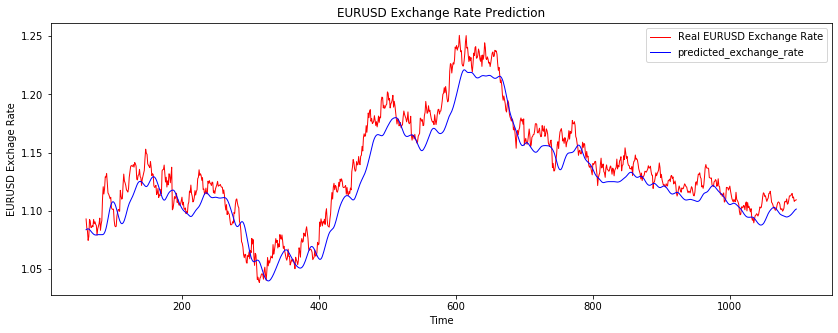

In [23]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(np.add(list(range(test.shape[0])), 60), test, color = 'red', label = 'Real EURUSD Exchange Rate', linewidth=1)
plt.plot(np.add(list(range(predicted_exchange_rate.shape[0])), 60), predicted_exchange_rate, color = 'blue', label = 'predicted_exchange_rate', linewidth=1)
plt.title('EURUSD Exchange Rate Prediction')
plt.xlabel('Time')
plt.ylabel('EURUSD Exchage Rate')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predicted_exchange_rate)
print(f'LSTM RNN MSE Error {error}')

LSTM RNN MSE Error 0.00025812571584694905


In [28]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predicted_exchange_rate)
print(f'LSTM RNN MSE Error: {error}')

LSTM RNN MSE Error: [0.01606629]
